<a href="https://colab.research.google.com/github/VictoriaRe/HSE-DataScience/blob/master/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[3 points] Delelop language model, which generates texts from wikipedia. Use WikiText-2 dataset, also available in torchtext.datasets. Use sentencepiece or tokenizers library for text tokenization. Pay attention to vocab size, probably subword tokens are better.
Your model should be autogressive RNN.

[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.

[1 point] Try to use together (sentencepiece or tokenizers), torchtext.datasets, and torchtext.data.BPTTIterator
Text generation should be terminated when either max length is reached or terminal symbol is generated. Explore several inference techniques:

[1 point] Argmax

[1 point] Beamsearch

[1 point] Sampling from probabilty distribution with temperature

[1 point] Nucleus sampling

[1 point] Top-k sampling

For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

In [1]:
!pip install tokenizers

     |████████████████████████████████| 3.8MB 2.8MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import LanguageModelingDataset

from torchtext.data import BPTTIterator
import torch as tt

from torchtext.datasets import WikiText2
from torchtext import data

from tokenizers import SentencePieceBPETokenizer

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
WikiText2.download("./data")

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 42.2MB/s]


extracting


'./data/wikitext-2/wikitext-2'

In [0]:
import os

with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.test.tokens"), "r") as test_fd:
    test = test_fd.read()

In [0]:
with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.train.tokens"), "r") as train_fd:
    train = train_fd.read()

In [0]:
with open(os.path.join(".", "data", "wikitext-2", "wikitext-2", "wiki.valid.tokens"), "r") as valid_fd:
    valid = valid_fd.read()

In [12]:
len(test)

1255018

In [13]:
len(train)

10780437

In [14]:
len(valid)

1120192

In [0]:
def extra_del(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    text = re.sub(r'=\s.{3,15}=\s', '', text)
    text = re.sub(r'\s@', ' ', text)
    text = re.sub(r'@\s', ' ', text)
    return text

In [0]:
def special_tokens(text):
    eos = [' .', ' !', ' ?', ' ? !', ' \'n']
    eos_token = '<eos> <sos>'
    for element in eos:
        text = text.replace(element, ' ' + eos_token + ' ')
    text = re.sub(r'<sos>\s{2,10}<eos>', ' ', text)
    while '  ' in text:
        text = re.sub(r'\s{2,10}', ' ', text)
    text = '<sos> ' + text
    return text.lower()

In [0]:
def prep (text):
  clean = extra_del(text)
  fin = special_tokens(clean)
  return fin

In [0]:
train_prep = prep(train)

In [0]:
test_prep = prep(test)

In [0]:
valid_prep = prep(valid)

In [0]:
with open(os.path.join(".", "data", "train_prep.tokens"), "w", encoding="UTF-8") as clean_fd:
    clean_fd.write(train_prep)

with open(os.path.join(".", "data", "test_prep.tokens"), "w", encoding="UTF-8") as clean_fd:
    clean_fd.write(test_prep)

In [0]:
train_tokenizer = SentencePieceBPETokenizer()
train_tokenizer.add_special_tokens(["<eos>", "<unk>", "<sos>"])
train_tokenizer.train([os.path.join(".", "data", "train_prep.tokens"), os.path.join(".", "data", "test_prep.tokens")], vocab_size=20000)

In [26]:
print(prep("All you have to do is to be ready for some action now"))
out = train_tokenizer.encode(prep("All you have to do is to be ready for some action now"))
print(out.ids)
print(out.tokens)

<sos> all you have to do is to be ready for some action now
[2, 489, 1051, 513, 277, 759, 334, 277, 296, 6989, 306, 649, 2128, 1188]
['<sos>', '▁all', '▁you', '▁have', '▁to', '▁do', '▁is', '▁to', '▁be', '▁ready', '▁for', '▁some', '▁action', '▁now']


In [0]:
def tokenize(sent):
    sent = prep(sent)
    return train_tokenizer.encode(sent).tokens

In [0]:
TXT = torchtext.data.Field(lower=True, include_lengths=False, batch_first=False, 
                           tokenize=lambda sent: tokenize(sent))

In [29]:
train_data, val_data, test_data = WikiText2.splits(TXT)

wikitext-2-v1.zip:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 40.7MB/s]


extracting


In [0]:
TXT.build_vocab(train_data, val_data, test_data, min_freq=5)

train_iter, val_iter, test_iter = BPTTIterator.splits((train_data, val_data, test_data),
            batch_size=128, bptt_len=50, repeat=False, device = DEVICE)

In [0]:
b = next(iter(train_iter))

In [33]:
def recover_text(vector):
    return [TXT.vocab.itos[v] for v in vector[0]]

print(recover_text(b.text.data.squeeze()))

print(recover_text(b.target.data.squeeze()))

['<sos>', '▁proceeded', '<sos>', '▁', '▁down', '▁and', '▁judgment', '▁organizations', '▁fitted', '▁intermitt', '▁the', '▁the', '▁he', '▁is', '▁are', '▁in', '▁beyond', '▁', '▁cbs', '▁,', '<sos>', '▁and', '▁show', '▁caught', '▁', '<sos>', '▁', '▁new', '▁known', '▁he', '2', 'd', '<sos>', '▁mar', '▁the', '▁the', '▁ulysses', '▁8', '▁parodies', '▁the', '▁human', '▁', '▁consoles', '▁of', '▁asserted', '▁the', '▁', '▁won', '▁pract', '▁the', '▁lad', '▁act', '▁of', '▁21', '<sos>', '<sos>', '▁=', '<sos>', '▁', '▁winning', '▁league', '▁camps', '▁contains', '<sos>', '▁as', '▁releases', '▁,', '▁became', '▁urging', '▁desperate', '▁born', '▁modified', '▁role', '▁from', '<eos>', '▁song', '▁september', '▁about', '▁have', '<sos>', '▁sean', '<eos>', '▁', '<eos>', 'ually', '▁his', '▁researchers', '▁in', '▁with', '▁allowed', '▁in', '▁and', '▁used', '▁,', '▁significant', '▁"', 'ched', '<eos>', '▁in', '▁although', '▁15', '▁', '▁percussion', '▁than', '▁emperor', '▁biology', '▁cbs', '<unk>', '▁mm', '▁', '<eos>',

In [0]:
import torch.nn as nn
import torch as tt

class AutoRegressive(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(AutoRegressive, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, "text") else batch
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x)
        
        return x.transpose(1,2)

In [0]:
import torch.optim as optim

model = AutoRegressive(len(TXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [0]:
import numpy as np

def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
      
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i + 1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):
  
    model = model
    criterion = criterion

    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    for epoch in range(n_epochs):
        train_loss = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss = _test_epoch(model, valid_iterator, criterion)

        valid_loss = valid_loss
        print('epoch %d, validation loss %.5f' % (epoch, valid_loss))
        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history

In [45]:
history = nn_train(model, train_iter, val_iter, criterion, optimizer, scheduler=scheduler, 
        n_epochs = 3, early_stopping = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



epoch 0, validation loss 4.56306



epoch 1, validation loss 3.46687



epoch 2, validation loss 2.78396


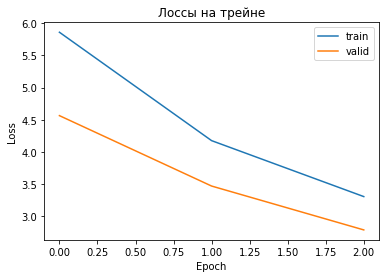

In [46]:
plt.title('Лоссы на трейне')

plt.plot(list(history["train_loss"]))
plt.plot(list(history["valid_loss"]))
plt.legend(('train', 'valid'))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [0]:
def back2text(vector):
    return [train_tokenizer.id_to_token(idx) for idx in vector]

In [0]:
def predict(model, func):
    seq_max_len = 80
    with tt.no_grad():
        current_token = train_tokenizer.token_to_id("<sos>")
        seq = [current_token]
        seq_len = 0
        while seq_len < seq_max_len and current_token != train_tokenizer.token_to_id("<eos>"):
            pred = model(tt.tensor([seq]))[:,:,-1]
            current_token = func(pred)
            seq.append(current_token)
            seq_len += 1
    return seq

In [55]:
argmax_func = lambda pred: tt.argmax(pred).item()

out = predict(model, argmax_func)
print(back2text(out))

['<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '<sos>']


In [0]:
def sampling_prob_dist_tempr(pred):
    temp = 0.8
    tau_logits = tt.exp(pred / temp) / tt.sum(tt.exp(pred / temp))
    probs = tau_logits.squeeze().numpy() / np.sum(tau_logits.squeeze().numpy())
    return np.random.choice(len(probs), 1, p=probs)[0]

In [58]:
out = predict(model, sampling_prob_dist_tempr)
print(back2text(out))

['<sos>', '%', '&', '<sos>', 'í', '+', '[', '▁be', '<sos>', '%', '<sos>', '&', '<sos>', '%', '<sos>', '&', '▁fer', ',', '▁stated', '<sos>', '%', '<sos>', '&', ',', '▁maint', "'", '6', 'r', '▁bor', '+', '▁primarily', '4', '▁gay', '<sos>', '%', '<sos>', '&', '▁technical', '▁flag', '<sos>', '%', '&', '<sos>', '▁abuse', '<sos>', '%', '<sos>', '&', '<sos>', '%', '&', '<sos>', '<sos>', '%', '<sos>', '&', 'ic', 'pos', 'ò', '<sos>', '%', '<sos>', '&', '<sos>', '<sos>', '%', '&', '<sos>', ')', '$', '▁num', 'ream', '<sos>', '*', '$', '▁rhode', ')', '<sos>', '%', '&', '<sos>']


In [0]:
import torch.nn.functional as F

In [0]:
def top_k(pred):

    top_k = 7000
    indices_to_remove = pred < tt.topk(pred, top_k)[0][..., -1, None]
    pred[indices_to_remove] = -float('Inf')
    probs = F.softmax(pred, dim=-1)
    p = tt.multinomial(probs, num_samples=1)

    return p

In [65]:
out = predict(model, top_k)
print(back2text(out))

['<sos>', '%', '<sos>', '▁perman', '.', '▁composer', '\\', '▁can', 'ators', '<sos>', '%', 'ized', '▁receiving', 'teries', 'r', 'aster', 'ch', '▁leaving', 'rup', '▁architect', '჻', '(', '▁played', '▁description', '(', '7', '▁155', ')', ')', 'atisf', '<sos>', '%', '<sos>', '&', 'c', '▁counter', '▁own', ';', '▁mom', "'", '▁invest', '<sos>', '<sos>', '▁milit', ')', '▁extra', '▁barbar', '\\', '▁imm', '▁others', '*', 'ivation', 'ó', '▁196', '▁supply', "'", "'", '▁kansas', '×', '▁196', 'os>', '▁59', '▁tre', '▁branch', '$', '▁executive', '<', ',', '▁left', 'ト', '<sos>', '%', '&', '▁196', '▁nomin', '$', '▁stated', '▁goldberg', '(', ',', '▁arg']


Реализация beam search из дз1

In [0]:
def beam_search(model, src, src_mask, max_len=20, k=5, offset=0):
    memory = model.encode(src, src_mask)
    start_token = TGT.vocab.stoi["<s>"]
    end_token = TGT.vocab.stoi["</s>"]
    ys = torch.ones(1, 1).fill_(start_token).type_as(src.data)
    
    beam = [(ys, 0)]
    for i in range(max_len):
        candidates= []
        candidates_proba = []
        for snt, snt_proba in beam:
            if snt[0][-1] == end_token:
                candidates.append(snt)
                candidates_proba.append(snt_proba)
            else:
                proba = model.decode(memory, src_mask, snt,
                                     subsequent_mask(snt.size(1)).type_as(src.data))
                proba = proba[0][i]
                best_k = torch.argsort(-proba)[:k].tolist()
                proba = proba.tolist()
                for tok in best_k:
                    candidates.append(torch.cat([snt, torch.ones(1, 1).type_as(src.data).fill_(tok)], dim=1))
                    candidates_proba.append(snt_proba + np.log(proba[tok])) 
         
        best_candidates = np.argsort(-np.array(candidates_proba))[offset:k+offset]
        beam = [(candidates[j], candidates_proba[j]) for j in best_candidates]
    
    return beam